# Train Detectron2 with Custom COCO Datasets

In [1]:
import detectron2
from detectron2.utils.logger import setup_logger

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import gdown
import torch

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

## Register your own data set in coco format

In [2]:
from detectron2.data.datasets import register_coco_instances

register_coco_instances('wamv_train', {}, 
                        '/home/arg/Mask-RCNN-Detectron2/datasets/WAM_V_S2_split_dir/train.json', 
                       '/home/arg/Mask-RCNN-Detectron2/datasets/WAM_V_S2_split_dir/train')
register_coco_instances('wamv_val', {}, 
                        '/home/arg/Mask-RCNN-Detectron2/datasets/WAM_V_S2_split_dir/val.json', 
                       '/home/arg/Mask-RCNN-Detectron2/datasets/WAM_V_S2_split_dir/val')

In [3]:
subt_metadata = MetadataCatalog.get("wamv_train")
dataset_dicts = DatasetCatalog.get("wamv_val")
subt_metadata


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



Metadata(evaluator_type='coco', image_root='/home/arg/Mask-RCNN-Detectron2/datasets/WAM_V_S2_split_dir/train', json_file='/home/arg/Mask-RCNN-Detectron2/datasets/WAM_V_S2_split_dir/train.json', name='wamv_train')

## Visualize dataset - make sure the data is loaded without problems

To verify the data loading is correct, let's visualize the annotations of randomly selected samples in the dataset.

{'file_name': '/home/arg/Mask-RCNN-Detectron2/datasets/WAM_V_S2_split_dir/val/Scene2_385.jpg', 'height': 480, 'width': 640, 'image_id': 79, 'annotations': [{'iscrowd': 0, 'bbox': [290.9925537109375, 215.338623046875, 60.899200439453125, 30.5848388671875], 'category_id': 1, 'segmentation': [[307, 229, 304, 228, 304, 229, 312, 216, 312, 217, 311, 218, 308, 218, 307, 219, 305, 219, 301, 223, 301, 225, 302, 226, 302, 229, 301, 230, 301, 233, 300, 234, 297, 234, 295, 236, 294, 236, 292, 238, 292, 241, 294, 243, 300, 243, 301, 242, 304, 242, 305, 241, 307, 241, 308, 240, 309, 240, 311, 238, 311, 237, 312, 236, 312, 232, 311, 231, 309, 231, 307, 233, 306, 232, 305, 233, 303, 233, 302, 232, 302, 225, 301, 224, 301, 223, 302, 222, 303, 223, 307, 219, 308, 219, 309, 218, 311, 218, 312, 219, 306, 225, 306, 226, 313, 219, 314, 219, 315, 218, 337, 218, 338, 219, 339, 219, 340, 220, 341, 220, 342, 221, 342, 222, 343, 223, 343, 224, 344, 225, 344, 232, 343, 233, 342, 233, 341, 234, 341, 235, 339, 237

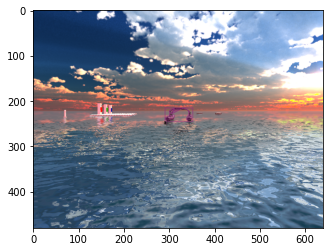

In [4]:
import random

for d in random.sample(dataset_dicts, 1):
    print(d)
    img = cv2.imread(d["file_name"])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    visualizer = Visualizer(img[:, :, ::-1], metadata=subt_metadata, scale=1)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1], cmap='nipy_spectral')
    #cv2.waitKey(0)

## Change configuration parameters
Now, let's fine-tune a coco-pretrained R50-FPN Mask R-CNN model on the dataset.

In [5]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo

cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("wamv_train",)
cfg.DATASETS.TEST = ("wamv_val", )
cfg.DATALOADER.NUM_WORKERS = 0 #Single thread
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo

cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # datasets classes
cfg.SOLVER.IMS_PER_BATCH = 4 #Batch size
ITERS_IN_ONE_EPOCH = 610 #dataset_imgs/batch_size  
cfg.SOLVER.MAX_ITER = (ITERS_IN_ONE_EPOCH * 50) # ITERS

cfg.SOLVER.BASE_LR = 0.00025  # pick a good LR
cfg.SOLVER.MOMENTUM = 0.9
cfg.SOLVER.WEIGHT_DECAY = 0.0001
cfg.SOLVER.GAMMA = 0.1
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.WARMUP_METHOD = "linear"
cfg.SOLVER.CHECKPOINT_PERIOD = ITERS_IN_ONE_EPOCH #Save training model interval


In [6]:
print(cfg.OUTPUT_DIR)
!ls

./output
02_UnityData_split.ipynb       output
README.md		       plain_train_net.py
Untitled.ipynb		       train-MaskRCNN-Containter_ship.ipynb
all_image		       train-MaskRCNN-SubT.ipynb
analyze_model.py	       train-MaskRCNN-TugShip.ipynb
bags			       train-MaskRCNN-Wamv.ipynb
benchmark.py		       train-MaskRCNN-sailboat_new.ipynb
convert-torchvision-to-d2.py   train-curve_show.ipynb
deploy			       train_net.py
eval-MaskRCNN-Wamv.ipynb       trained_model_result
eval_with_coco		       unity_detect.py
evaluate-MaskRCNN-SubT.ipynb   unity_detect_ros.py
extract_compress.py	       visualize_data.py
inference-MaskRCNN-Wamv.ipynb  visualize_json_results.py


## Training


In [7]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

trainer = DefaultTrainer(cfg)
trainer.resume_or_load(False)
trainer.train()

[11/01 16:54:27 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [11/01 16:54:27 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[11/01 16:54:27 d2.data.datasets.coco]: Loaded 800 images in COCO format from /home/arg/Mask-RCNN-Detectron2/datasets/WAM_V_S2_split_dir/train.json
[11/01 16:54:27 d2.data.build]: Removed 0 images with no usable annotations. 800 images left.
[11/01 16:54:27 d2.data.common]: Serializing 800 elements to byte tensors and concatenating them all ...
[11/01 16:54:27 d2.data.common]: Serialized dataset takes 0.94 MiB
[11/01 16:54:27 d2.data.dataset_mapper]: Augmentations used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[11/01 16:54:27 d2.data.build]: Using training sampler TrainingSampler


Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (5, 256, 1, 1) 

[11/01 16:54:28 d2.engine.train_loop]: Starting training from iteration 0
ERROR [11/01 16:54:28 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/home/arg/detectron2/detectron2/engine/train_loop.py", line 140, in train
    self.run_step()
  File "/home/arg/detectron2/detectron2/engine/train_loop.py", line 226, in run_step
    loss_dict = self.model(data)
  File "/home/arg/.local/lib/python3.6/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/arg/detectron2/detectron2/modeling/meta_arch/rcnn.py", line 157, in forward
    features = self.backbone(images.tensor)
  File "/home/arg/.local/lib/python3.6/site-packages/torch/nn/modules/module.py", line 550, in __call__
    result = self.forward(*input, **kwargs)
  File "/home/arg/detectron2/detectron2/modeling/backbone/fpn.py", line 123, in forward
    bottom_up_features = self.bottom_up(x)
  File "/home/arg/.local/lib/python3.6

RuntimeError: CUDA out of memory. Tried to allocate 108.00 MiB (GPU 0; 5.79 GiB total capacity; 4.16 GiB already allocated; 65.25 MiB free; 4.43 GiB reserved in total by PyTorch)

## Make a prediction

Download a pre-trained SubT model

In [11]:
#models_url = "https://drive.google.com/file/d/1Rt-vvZP6CMvB32rC-ZBk6mHpi0NnWVM5/view?usp=sharing"
models_name = "model_final.pth"
if not os.path.isfile("output/" + models_name):
    gdown.download(models_url, output="output/" + models_name, quiet=False)

print("Finished downloading models.") 

Finished downloading models.


In [12]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("wamv_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.


0.14677071571350098


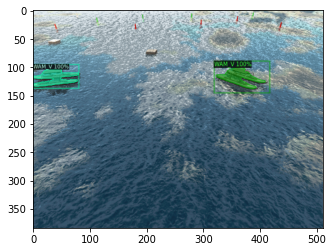

In [13]:
from detectron2.utils.visualizer import ColorMode
import random
import time

#print(dataset_dicts)
fn = '/home/arg/Mask-RCNN-Detectron2/datasets/test/36.main.jpg'
im = cv2.imread(fn)
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
#print(im)
t1 = time.time()
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=subt_metadata, 
               scale=0.8)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')
t2 = time.time()
print(t2 - t1)

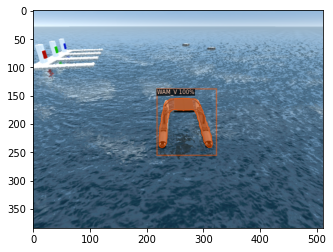

In [13]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(dataset_dicts, 2):    
    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    #print(im)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=subt_metadata, 
                   scale=0.8
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1], cmap='nipy_spectral')